## Visualize the results of the Linear Model Power analysis

In [8]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
#suppressPackageStartupMessages(library(patchwork))

In [9]:
plate <- "localhost220513100001_KK22-05-198_FactinAdjusted"  # Focus on plate 2

# Input files
lm_results_file <- file.path("results", paste0(plate, "_linear_model_cp_features.tsv"))
lm_power_file <- file.path("results", paste0(plate, "_power_analysis_cp_features_lm.tsv"))

# Output files
output_power_figure <- file.path("figures", paste0(plate, "_power_analysis_cp_lm.png"))

In [10]:
# Merge linear model results
lm_results_df <- readr::read_tsv(
    lm_results_file,
    col_types = readr::cols(.default="d", feature="c")
)
lm_power_df <- readr::read_tsv(
    lm_power_file,
    col_types = readr::cols(.default="d", feature="c")
)

# Merge for visualization
lm_data_df <- lm_results_df %>%
    dplyr::left_join(lm_power_df, by = "feature") %>%
    dplyr::arrange(estimated_sample_size) %>%
    dplyr::filter(estimated_sample_size < 100000) %>%  # Remove extreme outliers
    dplyr::filter(!is.na(power))

print(dim(lm_data_df))
head(lm_data_df)

[1] 491   9


feature,r2_score,cell_count_coef,treatment_dose_coef,u,v,sig_level,power,estimated_sample_size
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cytoplasm_Texture_DifferenceVariance_Actin_3_03_256,0.6156794,-0.0007223108,0.2784619,9,17985,9.90099e-05,0.8,39.19311
Cytoplasm_Texture_InverseDifferenceMoment_Actin_3_02_256,0.5077541,-0.0011283532,0.2410402,9,17985,9.90099e-05,0.8,51.53238
Cytoplasm_Texture_AngularSecondMoment_ER_3_01_256,0.4129538,-0.0006790381,0.2260912,9,17985,9.90099e-05,0.8,67.63817
Cytoplasm_Texture_SumEntropy_ER_3_03_256,0.4097407,0.0005023368,-0.2290020,9,17985,9.90099e-05,0.8,68.31423
Cytoplasm_Texture_InverseDifferenceMoment_ER_3_00_256,0.4089323,-0.0011122762,0.2134026,9,17985,9.90099e-05,0.8,68.48599
Cytoplasm_Texture_DifferenceVariance_ER_3_01_256,0.4032086,-0.0007418206,0.2217313,9,17985,9.90099e-05,0.8,69.72183


In [11]:
# Load feature data (for calculating n)
file_suffix = "_sc_norm_fs_cellprofiler_ic.csv.gz"
data_dir = file.path("..", "..", "..", "3.process_cfret_features", "data")
cp_file <- file.path(data_dir, paste0(plate, file_suffix))

cp_df <- readr::read_csv(
    cp_file,
    col_types = readr::cols(
        .default="d",
        Metadata_WellRow="c",
        Metadata_WellCol="c",
        Metadata_heart_number="c",
        Metadata_treatment="c",
        Metadata_dose="c",
        Metadata_Plate="c",
        Metadata_Well="c"
    )
)

n_samples <- dim(cp_df)[1]

print(dim(cp_df))
head(cp_df, 3)

New names:
• `` -> `...1`


[1] 17995   645


...1,Metadata_WellRow,Metadata_WellCol,Metadata_number_of_singlecells,Metadata_heart_number,Metadata_treatment,Metadata_dose,Metadata_ImageNumber,Metadata_Plate,Metadata_Well,⋯,Nuclei_Texture_InverseDifferenceMoment_PM_3_01_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_03_256,Nuclei_Texture_SumEntropy_ER_3_03_256,Nuclei_Texture_SumEntropy_Hoechst_3_00_256,Nuclei_Texture_SumEntropy_Mitochondria_3_03_256,Nuclei_Texture_SumEntropy_PM_3_01_256,Nuclei_Texture_SumVariance_ER_3_03_256,Nuclei_Texture_SumVariance_Hoechst_3_01_256,Nuclei_Texture_SumVariance_Mitochondria_3_03_256,Nuclei_Texture_SumVariance_PM_3_01_256
<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,A,9,357,9,drug_x,5uM,1,localhost220513100001_KK22-05-198_FactinAdjusted,A09,⋯,-1.2788029,-0.8897645,0.5844583,-0.7568114,1.6462852,1.6277442,-0.1302769,-0.32954013,0.16874427,0.22393503
1,A,9,357,9,drug_x,5uM,1,localhost220513100001_KK22-05-198_FactinAdjusted,A09,⋯,0.1400462,0.1777536,-1.0356146,-0.4881881,-0.9279062,-0.3785298,-0.4520701,-0.30924955,-0.17971123,-0.19329881
2,A,9,357,9,drug_x,5uM,1,localhost220513100001_KK22-05-198_FactinAdjusted,A09,⋯,-0.7494158,-1.6935892,0.3866221,0.9995438,1.1926342,1.1170768,-0.1127250,0.04806898,-0.02098493,0.01024755


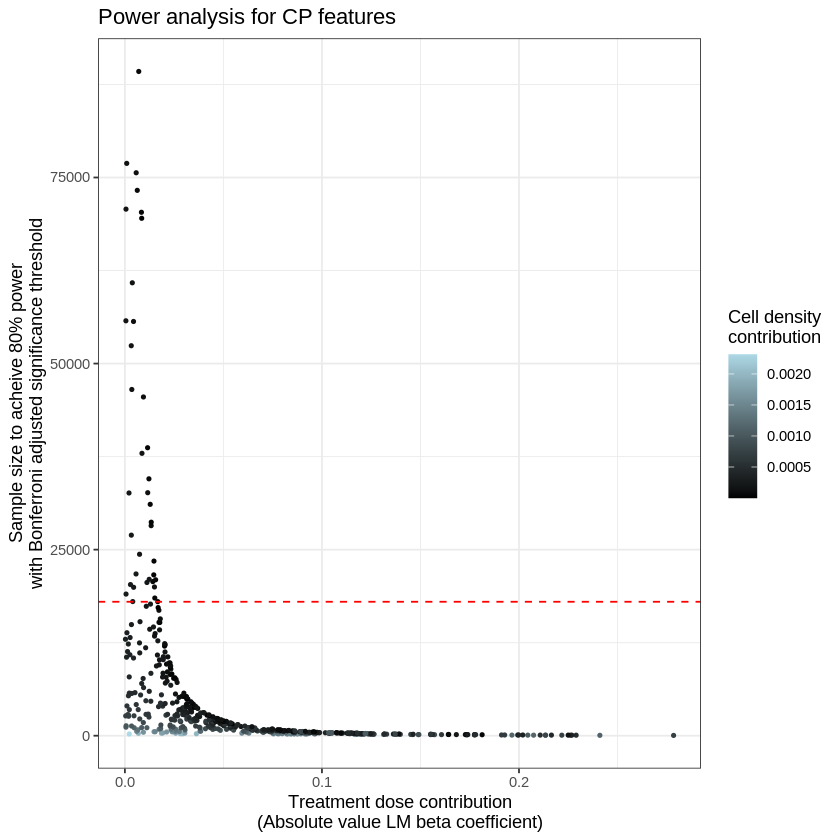

In [12]:
power_gg <- (
    ggplot(lm_data_df, aes(y = estimated_sample_size, x = abs(treatment_dose_coef)))
    + geom_point(aes(color = abs(cell_count_coef)), size = 0.8)
    + theme_bw()
    + xlab("Treatment dose contribution\n(Absolute value LM beta coefficient)")
    + ylab("Sample size to acheive 80% power\nwith Bonferroni adjusted significance threshold")
    + ggtitle("Power analysis for CP features")
    + geom_hline(yintercept = n_samples, linetype = "dashed", color = "red")
    + scale_color_gradient(name = "Cell density\ncontribution", low = "black", high = "lightblue")
)

power_gg

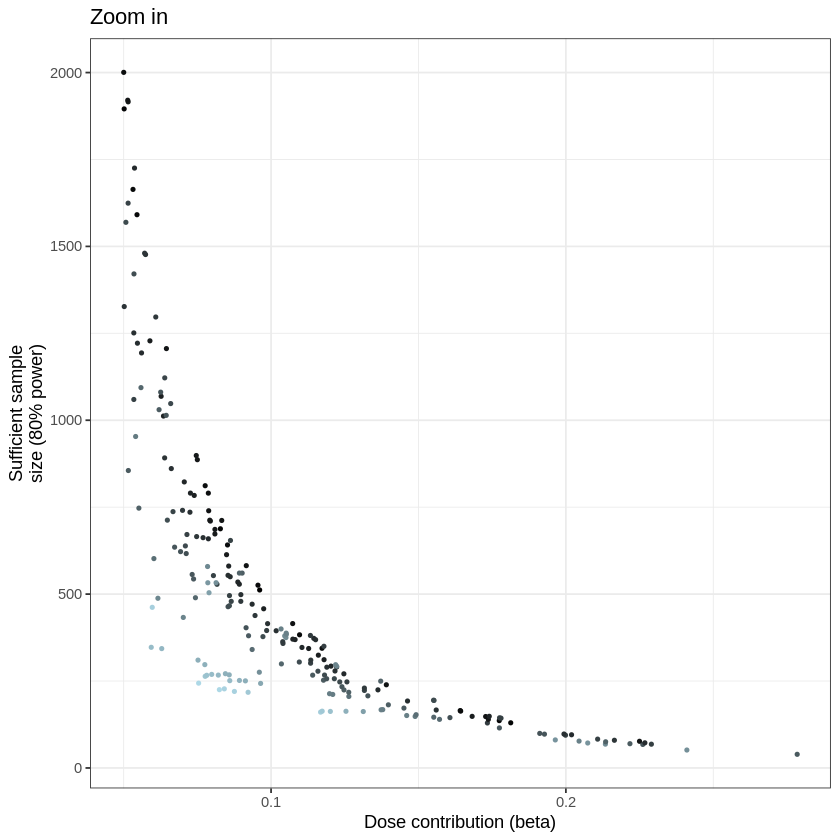

In [13]:
power_zoom_gg <- (
    ggplot(
        lm_data_df %>% dplyr::filter(abs(treatment_dose_coef) > 0.05),
        aes(y = estimated_sample_size, x = abs(treatment_dose_coef))
    )
    + geom_point(
        aes(color = abs(cell_count_coef)),
        size = 0.8,
        show.legend = FALSE
    )
    + theme_bw()
    + xlab("Dose contribution (beta)")
    + ylab("Sufficient sample\nsize (80% power)")
    + ggtitle("Zoom in")
    + scale_color_gradient(name = "Cell density\ncontribution", low = "black", high = "lightblue")
)

power_zoom_gg

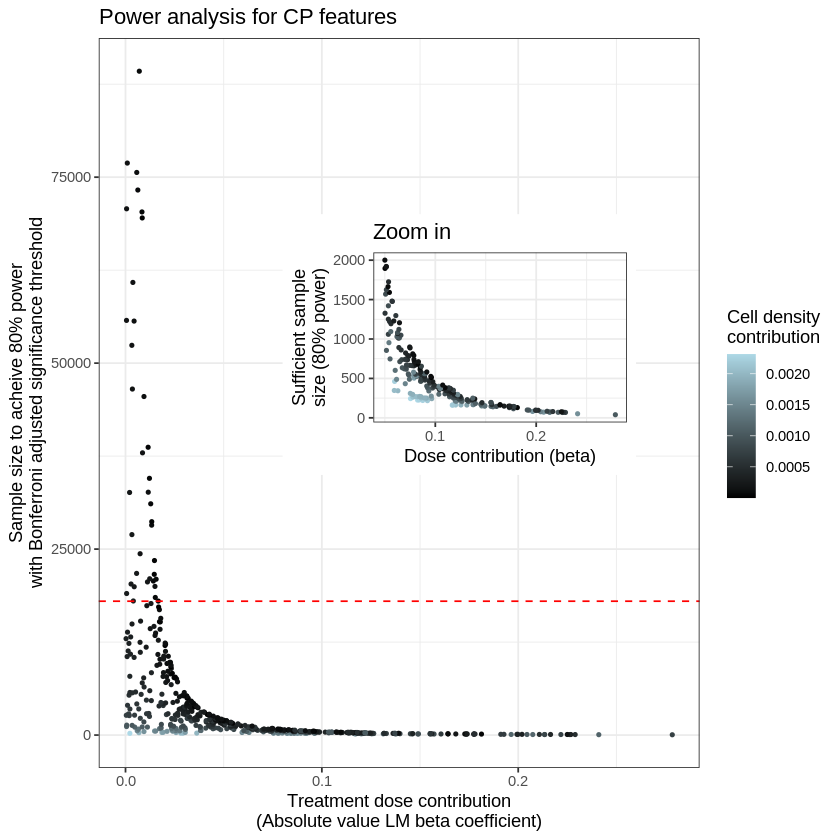

In [14]:
# Combine plots
combined_gg <- cowplot::ggdraw(
    power_gg
    + cowplot::draw_plot(
        power_zoom_gg,
        x = 0.08,
        y = 35000,
        width = .18,
        height = 35000
    )
)

ggsave(output_power_figure, combined_gg, width = 7, height = 6, dpi = 500)

combined_gg